# Tutorial: ADM initial data for scalar field collapse

## Author: Leo Werneck

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

0. [Introduction](#introduction)
1. [Step 1](#initialize_nrpy): Initialize core Python/NRPy+ modules
1. [Step 2](#adding_functions_to_dictionary): Adding C functions to the dictionary
    1. [Step 2.a](#scalar_field_id_spherical): `scalar_field_id_Spherical`
    1. [Step 2.b](#build_tridiagonal_system_from_input_spherical): `build_tridiagonal_system_from_input_Spherical`
        1. [Step 2.b.i](#tridiag_system_aux_vars): Auxiliary variables
        1. [Step 2.b.ii](#tridiag_system_main_diag): Main diagonal
        1. [Step 2.b.iii](#tridiag_system_upper_diag): Upper diagonal
        1. [Step 2.b.iv](#tridiag_system_lower_diag): Lower diagonal
        1. [Step 2.b.v](#tridiag_system_source_vector): Source vector $\vec{s}$
        1. [Step 2.b.vi](#tridiag_system_func_body): Writing the function's body
        1. [Step 2.b.vii](#tridiag_system_add_to_dict): Adding to dictionary
    1. [Step 2.c](#main_standalone): Example usage: The `main` function of a standalone code
    1. [Step 2.d](#add_all_to_dict): Add all functions in this notebook to the dictionary
1. [Step 3](#compiling_and_running): Compiling and running the C code
1. [Step 4](#validation): Validation against trusted solver
    1. [Step 4.a](#generate_trusted_id): Generating initial with [ScalarField/ScalarField_InitialData.py](../ScalarField/ScalarField_InitialData.py)
    1. [Step 4.b](#relative_error_plot): Plotting the relative error between the two initial data
1. [Step 5](#output_to_pdf): Output this module as $\LaTeX$-formatted PDF file

<a id='introduction'></a>

# Step 0: Introduction \[Back to [top](#toc)\]
$$\label{introduction}$$

$$
\partial^{2}_{r}\psi + \frac{2}{r}\partial_{r}\psi + \pi\Phi^{2}\psi = 0\ ,
$$

where $\psi \equiv e^{-\phi}$ is the conformal factor and $\Phi \equiv \partial_{r}\varphi$, with $\varphi$ the massless scalar field.

We discretize the Hamiltonian constraint using [second-order accurate finite differences](https://en.wikipedia.org/wiki/Finite_difference_coefficient). We get

$$
\frac{\psi_{i+1} - 2\psi_{i} + \psi_{i-1}}{\Delta r^{2}} + \frac{2}{r_{i}}\left(\frac{\psi_{i+1}-\psi_{i-1}}{2\Delta r}\right) + \pi\psi_{i}\Phi^{2}_{i} = 0\ ,
$$

or, by multiplying the entire equation by $\Delta r^{2}$ and then grouping the coefficients of each $\psi_{j}$:

$$
\boxed{\left(1-\frac{\Delta r}{r_{i}}\right)\psi_{i-1}+\left(\pi\Delta r^{2}\Phi_{i}^{2}-2\right)\psi_{i} + \left(1+\frac{\Delta r}{r_{i}}\right)\psi_{i+1} = 0}\ .
$$

We choose to set up a grid that is cell-centered, with:

$$
r_{i} = \left(i-\frac{1}{2}\right)\Delta r\ ,
$$

so that $r_{0} = - \frac{\Delta r}{2}$. This is a two-point boundary value problem, which we solve using the same strategy as [A&C](https://arxiv.org/pdf/1508.01614.pdf), described in eqs. (48)-(50):

\begin{align}
\left.\partial_{r}\psi\right|_{r=0} &= 0\ ,\\
\lim_{r\to\infty}\psi &= 1\ .
\end{align}

In terms of our grid structure, the first boundary condition (regularity at the origin) is written to second-order in $\Delta r$ as:

$$
\left.\partial_{r}\psi\right|_{r=0} = \frac{\psi_{1} - \psi_{0}}{\Delta r} = 0 \Rightarrow \psi_{0} = \psi_{1}\ .
$$

The second boundary condition (asymptotic flatness) can be interpreted as

$$
\psi_{N} = 1 + \frac{C}{r_{N}}\ (r_{N}\gg1)\ ,
$$

which then implies

$$
\partial_{r}\psi_{N} = -\frac{C}{r_{N}^{2}} = -\frac{1}{r_{N}}\left(\frac{C}{r_{N}}\right) = -\frac{1}{r_{N}}\left(\psi_{N} - 1\right) = \frac{1-\psi_{N}}{r_{N}}\ ,
$$

which can then be written as

$$
\frac{\psi_{N+1}-\psi_{N-1}}{2\Delta r} = \frac{1-\psi_{N}}{r_{N}}\Rightarrow \psi_{N+1} = \psi_{N-1} - \frac{2\Delta r}{r_{N}}\psi_{N} + \frac{2\Delta r}{r_{N}}\ .
$$

Substituting the boundary conditions at the boxed equations above, we end up with

\begin{align}
\left(\pi\Delta r^{2}\Phi^{2}_{1} - 1 - \frac{\Delta r}{r_{1}}\right)\psi_{1} + \left(1+\frac{\Delta r}{r_{1}}\right)\psi_{2} = 0\quad &(i=1)\ ,\\
\left(1-\frac{\Delta r}{r_{i}}\right)\psi_{i-1}+\left(\pi\Delta r^{2}\Phi_{i}^{2}-2\right)\psi_{i} + \left(1+\frac{\Delta r}{r_{i}}\right)\psi_{i+1} = 0\quad &(1<i<N)\ ,\\
2\psi_{N-1} + \left[\pi\Delta r^{2}\Phi^{2}_{N} - 2 - \frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)\right]\psi_{N} = - \frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)\quad &(i=N)\ .
\end{align}

This results in the following tridiagonal system of linear equations

$$
A \cdot \vec{\psi} = \vec{s}\Rightarrow \vec{\psi} = A^{-1}\cdot\vec{s}\ ,
$$

where

$$
A=\begin{pmatrix}
\left(\pi\Delta r^{2}\Phi^{2}_{1} - 1 - \frac{\Delta r}{r_{1}}\right) & \left(1+\frac{\Delta r}{r_{1}}\right) & 0 & 0 & 0 & 0 & 0\\
\left(1-\frac{\Delta r}{r_{2}}\right) & \left(\pi\Delta r^{2}\Phi_{2}^{2}-2\right) & \left(1+\frac{\Delta r}{r_{2}}\right) & 0 & 0 & 0 & 0\\
0 & \ddots & \ddots & \ddots & 0 & 0 & 0\\
0 & 0 & \left(1-\frac{\Delta r}{r_{i}}\right) & \left(\pi\Delta r^{2}\Phi_{i}^{2}-2\right) & \left(1+\frac{\Delta r}{r_{i}}\right) & 0 & 0\\
0 & 0 & 0 & \ddots & \ddots & \ddots & 0\\
0 & 0 & 0 & 0 & \left(1-\frac{\Delta r}{r_{N-1}}\right) & \left(\pi\Delta r^{2}\Phi_{N-1}^{2}-2\right) & \left(1+\frac{\Delta r}{r_{N-1}}\right)\\
0 & 0 & 0 & 0 & 0 & 2 & \left[\pi\Delta r^{2}\Phi^{2}_{N} - 2 - \frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)\right]
\end{pmatrix}\ ,
$$

$$
\vec{\psi} = 
\begin{pmatrix}
\psi_{1}\\
\psi_{2}\\
\vdots\\
\psi_{i}\\
\vdots\\
\psi_{N-1}\\
\psi_{N}
\end{pmatrix}\ ,
$$

and

$$
\vec{s} = 
\begin{pmatrix}
0\\
0\\
\vdots\\
0\\
\vdots\\
0\\
-\frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)
\end{pmatrix}
$$

<a id='initialize_nrpy'></a>

# Step 1: Initialize core Python/NRPy+ modules \[Back to [top](#toc)\]
$$\label{initialize_nrpy}$$

Let's start by importing all needed modules from Python and defining the quadratic function for error estimates. We also check if the system has GPU support.

In [1]:
# Step 1: Initialize core Python/NRPy+ modules
import sympy as sp           # SymPy: a computer algebra system written entirely in Python
import os,sys,shutil         # Standard Python modules for multiplatform OS-level functions
sys.path.append(os.path.join(".."))
import outputC as outC       # NRPy+: C code output functionality
import cmdline_helper as cmd # NRPy+: Multi-platform Python command-line interface

# Step 1.a: Create all output directories needed by this tutorial
#           notebook, removing previous instances if they exist
Ccodesdir = os.path.join("Scalar_Field_ID")
Coutdir   = os.path.join(Ccodesdir,"out")
for dir in [Ccodesdir,Coutdir]:
    if os.path.exists(dir):
        shutil.rmtree(dir)
    cmd.mkdir(dir)

<a id='adding_functions_to_dictionary'></a>

# Step 2: Adding C functions to the dictionary \[Back to [top](#toc)\]
$$\label{adding_functions_to_dictionary}$$

We now write all the C functions that we will need to generate initial data for a massless scalar field in spherical symmetry.

<a id='scalar_field_id_spherical'></a>

## Step 2.a: `scalar_field_id_Spherical` \[Back to [top](#toc)\]
$$\label{scalar_field_id_spherical}$$

We now write the Python function which will add the C function `scalar_field_id_Spherical()` to our C functions dictionary. The function `scalar_field_id_Spherical()` is the one called by the user when generating scalar field initial data in Spherical coordinates. It solves the tridiagonal system described in the [Introduction](#introduction) using functions from the open-sourced [GNU Scientific Library (gsl)](https://www.gnu.org/software/gsl/).

In [2]:
# Step 2: Adding C functions to the dictionary
# Step 2.a: scalar_field_id_Spherical
def add_to_Cfunction_dict__scalar_field_id_Spherical():
    desc = """
(c) 2021 Leo Werneck

This function sets spherically symmetric scalar field
initial data in spherical coordinates by solving the
Hamiltonian constraint for the conformal factor

           psi := exp(-phi) .

This is done by solving the elliptic ODE

    nabla^{2}psi = -2 pi rho psi^{5} ,
    
where rho := n_{mu}n_{nu}T^{mu nu} for a massless
scalar field is given by

    rho = psi^{-4} ( partial_{r}phi )^{2} / 2 ,

where phi := phi(r) is the initial profile of the scalar
field. We thus obtain
 .-----------------------------------------------------------.
 | partial_{r}^{2}psi + (2/r)partial_{r}psi = - pi Phi^2 psi | ,
 .-----------------------------------------------------------.
where we have used the notation Phi := partial_{r}phi.

We obtain psi from the above ODE by writing the problem as a
tridiagonal system, which is then solved using the GNU
Scientific Library (gsl).

"""
    includes = ["<gsl/gsl_vector.h>",
                "<gsl/gsl_linalg.h>",
                "NRPy_basic_defines.h",
                "NRPy_function_prototypes.h"]
    prefunc  = ""
    c_type   = "void"
    name     = "scalar_field_id_Spherical"
    params   = """const int Nr,const REAL eta,const REAL r0,const REAL sigma,const REAL rmax,REAL *restrict psi"""
    body     = """
  // Step 1: Declare all needed gsl vectors
  gsl_vector *main_diag  = gsl_vector_alloc(Nr);
  gsl_vector *upper_diag = gsl_vector_alloc(Nr-1);
  gsl_vector *lower_diag = gsl_vector_alloc(Nr-1);
  gsl_vector *sources    = gsl_vector_alloc(Nr);
  gsl_vector *solution   = gsl_vector_alloc(Nr);

  // Step 2: Build the tridiagonal matrix based on user input
  build_tridiagonal_system_from_input_Spherical(Nr,eta,r0,sigma,rmax,
                                                main_diag,upper_diag,lower_diag,sources);

  // Step 3: Solve the tridiagonal system
  gsl_linalg_solve_tridiag(main_diag,upper_diag,lower_diag,sources,solution);

  // Step 4: Copy solution to psi array
  for(int i=0;i<Nr;i++) psi[i] = gsl_vector_get(solution,i);

  // Step 5: Free memory for all gsl vectors
  gsl_vector_free(main_diag);
  gsl_vector_free(upper_diag);
  gsl_vector_free(lower_diag);
  gsl_vector_free(sources);
  gsl_vector_free(solution);
"""
    loopopts = ""
    outC.add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,enableCparameters=False)

<a id='build_tridiagonal_system_from_input_spherical'></a>

## Step 2.b: `build_tridiagonal_system_from_input_Spherical` \[Back to [top](#toc)\]
$$\label{build_tridiagonal_system_from_input_spherical}$$

We now write the Python function that will add the C function `build_tridiagonal_system_from_input_Spherical` to our C functions dictonary. For the sake of the reader, we break this task into the following subtasks:

1. In [Step 2.b.i](#tridiag_system_aux_vars) we write the C code for all the auxiliary variables we need.
1. In [Step 2.b.ii](#tridiag_system_main_diag) we write the C code for the main diagonal of the tridiagonal matrix $A$ defined in [the Introduction](#introduction).
1. In [Step 2.b.iii](#tridiag_system_upper_diag) we write the C code for the upper diagonal of the tridiagonal matrix $A$ defined in [the Introduction](#introduction).
1. In [Step 2.b.iv](#tridiag_system_lower_diag) we write the C code for the lower diagonal of the tridiagonal matrix $A$ defined in [the Introduction](#introduction).
1. In [Step 2.b.v](#tridiag_system_source_vector) we write the C code for the vector of source terms $\vec{s}$  defined in [the Introduction](#introduction).

<a id='tridiag_system_aux_vars'></a>

### Step 2.b.i: Auxiliary variables \[Back to [top](#toc)\]
$$\label{tridiag_system_aux_vars}$$

In order to set the elements of the tridiagonal matrix $A$ and the source vector $\vec{s}$ we need to compute a few auxiliary quantities. The most important of these is the initial profile of the scalar field. We will implement here a [Gaussian](https://en.wikipedia.org/wiki/Gaussian_function) pulse of the form

$$
\varphi(r) = \eta \exp\left[-\left(\frac{r-r_{0}}{\sigma}\right)^{2}\right].
$$

where $\eta$ is the amplitude, $r_{0}$ is the center of the pulse, $\sigma$ its width, and $r$ is the radial coordinate. The auxiliary variable that we need for our tridiagonal system is

$$
\Phi(r) = \partial_{r}\varphi(r),
$$

which we will compute below using [SymPy](https://www.sympy.org/)'s symbolic differentiation. This provides greater flexibility when implementing different initial scalar field profiles, which will be added in the future.

In [3]:
# Step 2.b: build_tridiagonal_system_from_input_Spherical
# Step 2.b.i: auxiliary variables
def aux_vars_string():

    # Step 2.b.i.A: Declare eta, r, r0, sigma as SymPy variables
    eta,r,r0,sigma = sp.symbols("eta r r0 sigma",real=True)

    # Step 2.b.i.B: Implement initial scalar field profile
    phi = eta * sp.exp( - ((r-r0)/sigma)**2 )

    # Step 2.b.i.C: Compute Phi := partial_{r}phi
    Phi = sp.diff(phi,r)

    # Step 2.b.i.D: Set a few basic auxiliary variables used by our C code
    string = """
        // Auxiliary variables
        const REAL r = (i_r+0.5) * dr;
        const REAL source_N = -(2*dr/r) * (1.0+dr/r);
    """

    # Step 2.b.i.E: Output the symbolic expression for Phi to C code
    string += outC.outputC(Phi,"const REAL Phi","returnstring",
                             params="includebraces=False,outCverbose=False,preindent=2").replace("double","REAL")

    # Step 2.b.i.F: Set other useful auxiliary variables
    string += """    const REAL r2 = r*r;
        const REAL dr2  = dr*dr;
        const REAL Phi2 = Phi*Phi;
    """
    return string

<a id='tridiag_system_main_diag'></a>

### Step 2.b.ii: Main diagonal \[Back to [top](#toc)\]
$$\label{tridiag_system_main_diag}$$

We write the C code which implements the main diagonal of the tridiagonal matrix $A$:

$$
{\rm diag}_{\rm main}
=
\begin{pmatrix}
\left(\pi\Delta r^{2}\Phi^{2}_{0} - 1 - \frac{\Delta r}{r_{1}}\right)\\
\left(\pi\Delta r^{2}\Phi^{2}_{1}-2\right)\\
\vdots\\
\left(\pi\Delta r^{2}\Phi^{2}_{i}-2\right)\\
\vdots\\
\left(\pi\Delta r^{2}\Phi^{2}_{N_{r}-2} - 2\right)\\
\left[\pi\Delta r^{2}\Phi^{2}_{N_{r}-1} - 2 - \frac{2\Delta r}{r_{N_{r}-1}}\left(1+\frac{\Delta r}{r_{N_{r}-1}}\right)\right]\\
\end{pmatrix}
=
\begin{pmatrix}
\left(\pi\Delta r^{2}\Phi^{2}_{0} - 2\right)\\
\left(\pi\Delta r^{2}\Phi^{2}_{1} - 2\right)\\
\vdots\\
\left(\pi\Delta r^{2}\Phi^{2}_{i} - 2\right)\\
\vdots\\
\left(\pi\Delta r^{2}\Phi^{2}_{N_{r}-2}-2\right)\\
\left(\pi\Delta r^{2}\Phi^{2}_{N_{r}-1} - 2\right)\\
\end{pmatrix}
+
\left.\begin{pmatrix}
1 - \frac{\Delta r}{r_{0}}\\
0\\
\vdots\\
0\\
\vdots\\
0\\
- \frac{2\Delta r}{r_{N_{r}-1}}\left(1+\frac{\Delta r}{r_{N_{r}-1}}\right)
\end{pmatrix}\quad \right\}N_{r}\text{ elements}
$$

In [4]:
# Step 2.b.ii: Main diagonal
def main_diag_string():
    string = """
    // Set main diagonal element
    const REAL main_diag_elem = (M_PI * dr2 * Phi2 - 2.0) + (i_r==0)*(1.0 - dr/r) + (i_r==Nr-1)*( source_N );
    gsl_vector_set(main_diag,i_r,main_diag_elem);
"""
    return string

<a id='tridiag_system_upper_diag'></a>

### Step 2.b.iii: Upper diagonal \[Back to [top](#toc)\]
$$\label{tridiag_system_upper_diag}$$

Next we write the C code which implements the upper diagonal of the tridiagonal matrix $A$:

$$
{\rm diag}_{\rm upper}
=
\left.\begin{pmatrix}
1+\frac{\Delta r}{r_{0}}\\
1+\frac{\Delta r}{r_{1}}\\
\vdots\\
1+\frac{\Delta r}{r_{i}}\\
\vdots\\
1+\frac{\Delta r}{r_{N_{r}-3}}\\
1+\frac{\Delta r}{r_{N_{r}-2}}
\end{pmatrix}\quad\right\}N_{r}-1\text{ elements}
$$

In [5]:
# Step 2.b.iii: Upper diagonal
def upper_diag_string():
    string = """
    // Set upper diagonal element
    if( i_r < Nr-1 ) {
      const REAL upper_diag_elem = 1.0 + dr/r;
      gsl_vector_set(upper_diag,i_r,upper_diag_elem);
    }
"""
    return string

<a id='tridiag_system_lower_diag'></a>

### Step 2.b.iv: Lower diagonal \[Back to [top](#toc)\]
$$\label{tridiag_system_lower_diag}$$

We then write the C code which implements the lower diagonal of the tridiagonal matrix $A$:

$$
{\rm diag}_{\rm lower}
=
\left.\begin{pmatrix}
1-\frac{\Delta r}{r_{1}}\\
1-\frac{\Delta r}{r_{2}}\\
\vdots\\
1-\frac{\Delta r}{r_{i}}\\
\vdots\\
1-\frac{\Delta r}{r_{N_{r}-2}}\\
2
\end{pmatrix}\quad\right\}N_{r}-1\text{ elements}
$$

In [6]:
# Step 2.b.iv: Lower diagonal
def lower_diag_string():
    string = """
    // Set lower diagonal element
    if( i_r < Nr-1 ) {
      const REAL rp              = r + dr;
      const REAL tmp             = dr/rp;
      const REAL lower_diag_elem = 1.0 - tmp + (i_r==Nr-2)*( 1.0 + tmp ) ;
      gsl_vector_set(lower_diag,i_r,lower_diag_elem);
    }
"""
    return string

<a id='tridiag_system_source_vector'></a>

### Step 2.b.v: Source vector $\vec{s}$ \[Back to [top](#toc)\]
$$\label{tridiag_system_source_vector}$$

Finally, we write the C code which implements the source vector $\vec{s}$:

$$
\vec{s} = 
\begin{pmatrix}
0\\
0\\
\vdots\\
0\\
\vdots\\
0\\
-\frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)
\end{pmatrix}
$$

In [7]:
# Step 2.b.vi: Source vector
def sources_string():
    string = """
    // Set source vector element
    const REAL source_elem = 0.0 + (i_r==Nr-1)*( source_N );
    gsl_vector_set(sources,i_r,source_elem);
"""
    return string

<a id='tridiag_system_func_body'></a>

### Step 2.b.vi: Writing the function's body \[Back to [top](#toc)\]
$$\label{tridiag_system_func_body}$$

We now combine all the previous functions we have defined in Step 2.b into a single function which is responsible for generating the body of the function `build_tridiagonal_system_from_input_Spherical`.

In [8]:
# Step 2.b.vi: Function body
def tridiagonal_system_body():
    body  = """
  // Compute the step size from input
  const REAL dr = rmax / Nr;

  // Initialize the tridiagonal system
  for(int i_r=0;i_r<Nr;i_r++) {
"""
    body += aux_vars_string()+main_diag_string()+upper_diag_string()+lower_diag_string()+sources_string()
    body += "\n  }\n"
    
    return body

<a id='tridiag_system_add_to_dict'></a>

### Step 2.b.vii: Adding to dictionary \[Back to [top](#toc)\]
$$\label{tridiag_system_add_to_dict}$$

Armed with everything that we need, we now write the Python function that adds the C function `build_tridiagonal_system_from_input_Spherical` to our C functions dictionary.

In [9]:
# Step 2.b.vii: Add build_tridiagonal_system_from_input_Spherical to C functions dictionary
def add_to_Cfunction_dict__build_tridiagonal_system_from_input_Spherical():
    desc = """
(c) 2021 Leo Werneck

This function builds the tridiagonal system we need
to solve to obtain the scalar field initial data.

"""
    includes = ["<gsl/gsl_vector.h>","NRPy_basic_defines.h"]
    prefunc  = ""
    c_type   = "void"
    name     = "build_tridiagonal_system_from_input_Spherical"
    params   = """const int Nr,const REAL eta,const REAL r0,const REAL sigma,const REAL rmax,
                  gsl_vector *restrict main_diag,gsl_vector *restrict upper_diag,
                  gsl_vector *restrict lower_diag,gsl_vector *restrict sources"""
    body     = tridiagonal_system_body()
    loopopts = ""
    outC.add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,enableCparameters=False)

<a id='main_standalone'></a>

## Step 2.c: Example usage: The `main` function of a standalone code \[Back to [top](#toc)\]
$$\label{main_standalone}$$

We now write the `main` function of a standalone code which generates the scalar field initial data and outputs this data to a text file. To simplify the validation of our results with the [ScalarField/ScalarField_Initial_Data.py](../ScalarField/ScalarField_Initial_Data.py) NRPy+ module, the text file will contain 4 data columns on which we will write, from left-to-right,

1. The radius $r$;
1. The initial scalar field profile $\varphi$;
1. The conformal factor $\psi^{4}$;
1. The pre-collapsed lapse function $\alpha = \psi^{-2}$.

In [10]:
# Step 2.c: Standalone main fuction
def add_to_Cfunction_dict__scalar_field_id_standalone():
    desc = """
(c) 2021 Leo Werneck

Standalone scalar field initial data code.
"""
    includes = ["<gsl/gsl_vector.h>",
                "NRPy_basic_defines.h",
                "NRPy_function_prototypes.h"]
    prefunc  = ""
    c_type   = "int"
    name     = "main"
    params   = "int argc, char ** argv"
    body     = r"""
    // Step 1: Check correct usage
    if( argc != 7 ) {
      fprintf(stderr,"ERROR! Correct usage is: ./scalar_field_id_standalone Nr eta r0 sigma rmax outfile");
    }
    // Step 2: Set parameters
    const int Nr     = atoi(  argv[1]);
    const REAL eta   = strtod(argv[2],NULL);
    const REAL r0    = strtod(argv[3],NULL);
    const REAL sigma = strtod(argv[4],NULL);
    const REAL rmax  = strtod(argv[5],NULL);
    char filename[256];
    sprintf(filename,"%s",argv[6]);
    
    // Step 3: Allocate memory for the solution vector
    REAL *psi = (REAL *)malloc(sizeof(REAL)*Nr);

    // Step 4: Get the initial data
    scalar_field_id_Spherical(Nr,eta,r0,sigma,rmax,psi);
    
    // Step 5: Output initial data to file
    const REAL dr = rmax / Nr;
    FILE *fp = fopen(filename,"w");
    for(int i_r=0;i_r<Nr;i_r++) {
      const REAL r     = (i_r+0.5) * dr;
      const REAL tmp_0 = (r - r0)*(r - r0);
      const REAL tmp_1 = tmp_0/(sigma*sigma);
      const REAL phi   = eta * exp( -tmp_1 );
      const REAL psiL  = psi[i_r];
      const REAL psi2  = psiL*psiL;
      const REAL psi4  = psi2*psi2;
      const REAL alp   = 1.0/psi2;
      fprintf(fp,"%.15e %.15e %.15e %.15e\n",r,phi,psi4,alp);
    }
    fclose(fp);
    
    // Step 6: Free memory for the solution vector
    free(psi);
    
    // All done!
    return 0;
"""
    loopopts = ""
    outC.add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,enableCparameters=False)

<a id='add_all_to_dict'></a>

## Step 2.d: Add all functions in this notebook to the dictionary \[Back to [top](#toc)\]
$$\label{add_all_to_dict}$$

The function below calls all the Python functions we have defined in this tutorial notebook, adding all the C functions we will need to our C functions dictionary.

In [11]:
# Step 2.d: Add all scalar field ID C functions to dictionary
def ScalarField_ID_register_C_functions():
    add_to_Cfunction_dict__scalar_field_id_Spherical()
    add_to_Cfunction_dict__build_tridiagonal_system_from_input_Spherical()
    add_to_Cfunction_dict__scalar_field_id_standalone()

<a id='compiling_and_running'></a>

# Step 3: Compiling and running the C code \[Back to [top](#toc)\]
$$\label{compiling_and_running}$$

We now compile and run the standalone C code that will generate scalar field initial data and output it to an [ASCII](https://en.wikipedia.org/wiki/ASCII) file.

In [12]:
# Step 3: Compiling and running the C code
# Step 3.a: Add all C functions defined in this notebook to the dictionary
ScalarField_ID_register_C_functions()

# Step 3.b: Add core NRPy+ C functions and NRPy_basic_defines to dictionary
outC.outputC_register_C_functions_and_NRPy_basic_defines()

# Step 3.c: Generate NRPy_basic_defines.h
outC.construct_NRPy_basic_defines_h(Ccodesdir,enable_SIMD=False)

# Step 3.d: Generate NRPy_function_prototypes.h
outC.construct_NRPy_function_prototypes_h(Ccodesdir)

# Step 3.e: Set executable path
exec_name = "scalar_field_id_standalone"
exec_path = os.path.join(Ccodesdir,exec_name)

# Step 3.f: Compile the C code
cmd.new_C_compile(Ccodesdir,exec_name,addl_libraries=["-lgsl"])

# Step 3.g: Run the C code
cmd.Execute(exec_path, "20000 0.33 0 1 70 SFID.txt")

(EXEC): Executing `make -j10`...
ld: warning: dylib (/usr/local/opt/gsl/lib/libgsl.dylib) was built for newer macOS version (11.0) than being linked (10.16)
(BENCH): Finished executing in 0.6220970153808594 seconds.
Finished compilation.
(EXEC): Executing `./Scalar_Field_ID/scalar_field_id_standalone 20000 0.33 0 1 70 SFID.txt`...
(BENCH): Finished executing in 0.4209721088409424 seconds.


<a id='validation'></a>

# Step 4: Validation against trusted solver \[Back to [top](#toc)\]
$$\label{validation}$$

We now validate the results of our standalone code against the trusted solver implemented in the [ScalarField/ScalarField_InitialData.py](../ScalarField/ScalarField_InitialData.py) NRPy+ module.

<a id='generate_trusted_id'></a>

## Step 4.a: Generating initial with [ScalarField/ScalarField_InitialData.py](../ScalarField/ScalarField_InitialData.py) \[Back to [top](#toc)\]
$$\label{generate_trusted_id}$$

Generate the same initial data we have generated with the C code using our trusted solver

In [13]:
# Step 4.a: Generating trusted initial data
# Step 4.a.i: Import the ScalarField/ScalarField_InitialData.py
import ScalarField.ScalarField_InitialData as SFID

# Step 4.a.ii: Generate the initial data
outfile   = "SFID-trusted.txt"
ID_family = "Gaussian_pulse"
eta       = 0.33
Nr        = 20000
r0        = 0
sigma     = 1
rmax      = 70
SFID.ScalarField_InitialData(outfile,Ccodesdir,ID_family,
                            eta,r0,sigma,Nr,rmax)

Generated the ADM initial data for the gravitational collapse 
of a massless scalar field in Spherical coordinates.

Type of initial condition: Scalar field: "Gaussian" Shell
                         ADM quantities: Time-symmetric
                        Lapse condition: Pre-collapsed
Parameters: amplitude         = 0.33,
            center            = 0,
            width             = 1,
            domain size       = 70,
            number of points  = 20000,
            Initial data file = SFID-trusted.txt.

Wrote to file Scalar_Field_ID/ID_scalar_field_ADM_quantities.h
Wrote to file Scalar_Field_ID/ID_scalar_field_spherical.h
Appended to file "Scalar_Field_ID/ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2.h"
Appended to file "Scalar_Field_ID/ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2.h"


<a id='relative_error_plot'></a>

## Step 4.b: Plotting the relative error between the two initial data \[Back to [top](#toc)\]
$$\label{relative_error_plot}$$

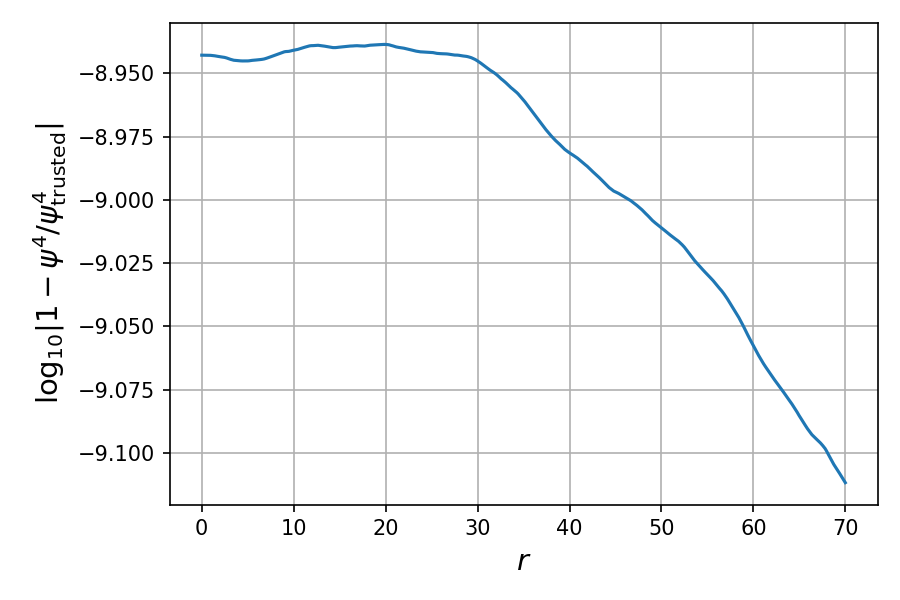

In [14]:
# Step 4.b: Plotting the relative error between the two initial data
# Step 4.b.i: Import required Python modules
import numpy as np                # NumPy: mathematical library for the Python programming language
import matplotlib.pyplot as plt   # Matplotlib: plotting library for the Python programming language
from IPython.display import Image # Image: Display images on Jupyter notebooks

# Step 4.b.ii: Read in the initial data files
rC ,sfC ,psi4C ,alpC  = np.loadtxt("SFID.txt").T
rPy,sfPy,psi4Py,alpPy = np.loadtxt("SFID-trusted.txt").T

# Step 4.b.iii: Generate the plot
fig = plt.figure()

plt.grid()
plt.xlabel(r"$r$",fontsize=14)
plt.ylabel(r"$\log_{10}\left|1 - \psi^{4}/\psi^{4}_{\rm trusted}\right|$",fontsize=14)
plt.plot(rC,np.log10(np.abs(1-psi4C/psi4Py)))
plt.tight_layout()

outfig = os.path.join(Coutdir,"validation.png")
plt.savefig(outfig,dpi=150,facecolor='white')
plt.close(fig)
Image(outfig)

<a id='output_to_pdf'></a>

# Step 5: Output this module as $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{output_to_pdf}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-ADM_Initial_Data-ScalarField_Ccode.pdf](Tutorial-ADM_Initial_Data-ScalarField_Ccode.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [15]:
# Step 5: Output this module as LaTeX formatted PDF file
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-ADM_Initial_Data-ScalarField_Ccode")

Created Tutorial-ADM_Initial_Data-ScalarField_Ccode.tex, and compiled LaTeX
    file to PDF file Tutorial-ADM_Initial_Data-ScalarField_Ccode.pdf
